In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_metadata_artefacts,
    load_map,
    load_odds,
    build_empty_dataframe,
    get_both_score_bet_df,
    get_exact_bet_df,
    add_real_prob,
    apply_final_treatment,
)
from GameProbs import GameProbs
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [56]:
metadata, gameid_to_outcome = load_metadata_artefacts("data/metadata.parquet")
odds = load_odds("data/odds.parquet")
print(metadata.shape)
print(odds.shape)

(16898, 8)
(2003933, 7)


In [57]:
metadata.head()

,League,GameId,Home,Away,Home_score,Away_score,Round,Outcome
0,Brasileirão Série A,2738735,São Paulo,Botafogo,2,0,Rodada 1,2 : 0
1,Brasileirão Série A,2738739,Atlético Mineiro,Avaí,2,1,Rodada 1,2 : 1
2,Brasileirão Série A,2738740,Chapecoense,Internacional,2,0,Rodada 1,2 : 0
3,Brasileirão Série A,2740879,Flamengo,Cruzeiro,3,1,Rodada 1,3 : 1
4,Brasileirão Série A,2740882,Grêmio,Santos,1,2,Rodada 1,1 : 2


In [54]:
odds.head(10)

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob
0,2738735,Bet365,h2h,,home,1.72,0.581395
1,2738735,Bet365,h2h,,draw,3.50,0.285714
2,2738735,Bet365,h2h,,away,4.75,0.210526
3,2738735,Bet365,over/under,0.5,over,1.08,0.925926
4,2738735,Bet365,over/under,0.5,under,8.00,0.125000
5,2738735,Bet365,over/under,1.5,over,1.42,0.704225
6,2738735,Bet365,over/under,1.5,under,2.75,0.363636
7,2738735,Bet365,over/under,2.5,over,2.30,0.434783
8,2738735,Bet365,over/under,2.5,under,1.60,0.625000
9,2738735,Bet365,over/under,3.5,over,4.33,0.230947


In [55]:
odds[odds.Market=='exact'].head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob
71,2738735,1xBet,exact,0 : 0,o,8.0,0.125000
72,2738735,1xBet,exact,0 : 1,o,12.0,0.083333
73,2738735,1xBet,exact,0 : 2,o,26.0,0.038462
74,2738735,1xBet,exact,0 : 3,o,101.0,0.009901
75,2738735,1xBet,exact,0 : 4,o,201.0,0.004975


## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [4]:
GAME_ID = "5254998" # Chapecoense x Flamengo
my_game = GameProbs(GAME_ID) 
df = my_game.build_dataframe()
df

,0,1,2,3,4,5,6
0,0.0289,0.0216,0.0100,0.0033,0.0008,0.0002,0.0000
1,0.0632,0.0598,0.0239,0.0076,0.0019,0.0004,0.0001
2,0.0880,0.0717,0.0354,0.0097,0.0024,0.0005,0.0001
3,0.0873,0.0688,0.0292,0.0108,0.0022,0.0004,0.0001
4,0.0692,0.0529,0.0220,0.0066,0.0022,0.0003,0.0001
5,0.0466,0.0347,0.0142,0.0042,0.0010,0.0004,0.0000
6,0.0558,0.0398,0.0158,0.0045,0.0011,0.0002,0.0001


In [5]:
gameid_to_outcome[GAME_ID]

'2 : 2'

In [6]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet', 'Megapari Sport', 'NetBet', 'Betobet', '18Bet', 'Mr Green Sport', 'Parimatch', 'Bet365']
odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]
print(odds_sample.shape)

# Join metadata info to the odds dataframe
odds_sample = pd.merge(odds_sample, metadata[['GameId', 'Home', 'Away']], on=['GameId'], how='left')
print(odds_sample.shape)

(680, 7)
(680, 9)


In [7]:
odds_sample = odds_sample[odds_sample.Market.isin(['exact', 'both_score'])].reset_index(drop=True)


In [8]:
odds_sample.sort_values(['Odd']).head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away
167,5254998,Betobet,both_score,,no,1.620,0.617284,Chapecoense,Flamengo
275,5254998,18Bet,both_score,,no,1.620,0.617284,Chapecoense,Flamengo
124,5254998,1xBet,both_score,,no,1.638,0.610501,Chapecoense,Flamengo
400,5254998,Megapari Sport,both_score,,no,1.638,0.610501,Chapecoense,Flamengo
196,5254998,NetBet,both_score,,no,1.660,0.602410,Chapecoense,Flamengo


In [9]:
odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)

In [37]:
df[::-1]

,0,1,2,3,4,5,6
6,0.0558,0.0398,0.0158,0.0045,0.0011,0.0002,0.0001
5,0.0466,0.0347,0.0142,0.0042,0.0010,0.0004,0.0000
4,0.0692,0.0529,0.0220,0.0066,0.0022,0.0003,0.0001
3,0.0873,0.0688,0.0292,0.0108,0.0022,0.0004,0.0001
2,0.0880,0.0717,0.0354,0.0097,0.0024,0.0005,0.0001
1,0.0632,0.0598,0.0239,0.0076,0.0019,0.0004,0.0001
0,0.0289,0.0216,0.0100,0.0033,0.0008,0.0002,0.0000


In [36]:
odds_sample

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
0,5254998,1xBet,exact,0 : 0,o,11.000,0.090909,Chapecoense,Flamengo,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0289,False
1,5254998,1xBet,exact,0 : 1,o,6.000,0.166667,Chapecoense,Flamengo,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0632,False
2,5254998,1xBet,exact,0 : 2,o,6.000,0.166667,Chapecoense,Flamengo,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0880,False
3,5254998,1xBet,exact,0 : 3,o,9.000,0.111111,Chapecoense,Flamengo,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0873,False
4,5254998,1xBet,exact,0 : 4,o,15.000,0.066667,Chapecoense,Flamengo,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0692,True
...,...,...,...,...,...,...,...,...,...,...,...,...
269,5254998,Megapari Sport,both_score,,no,1.638,0.610501,Chapecoense,Flamengo,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.4749,False
270,5254998,Mr Green Sport,both_score,,yes,2.000,0.500000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True
271,5254998,Mr Green Sport,both_score,,no,1.770,0.564972,Chapecoense,Flamengo,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.4749,False
272,5254998,Bet365,both_score,,yes,2.000,0.500000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True


In [50]:
map_bet = load_map('data/probs.json')
market = 'both_score'
both_score_normalized = pd.json_normalize(map_bet[market])

In [ ]:
both_score_normalized

In [46]:
import re
market = 'exact'
exact_normalized = pd.json_normalize(map_bet[market])
exact_normalized.columns = [re.sub( '.o', '', col) for col in exact_normalized.columns]
exact_normalized = pd.melt(exact_normalized, var_name='Scenario', value_name='BetMap')
exact_normalized['Market'] = market

In [52]:
map_bet['both_score'].keys()

dict_keys(['yes', 'no'])

In [47]:
exact_normalized

,Scenario,BetMap,Market
0,0 : 0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
1,0 : 1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
2,0 : 2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
3,0 : 3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
4,0 : 4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
5,0 : 5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
6,0 : 6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",exact
7,1 : 0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",exact
8,1 : 1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",exact
9,1 : 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",exact


In [45]:
both_score_normalized

,yes,no
0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ..."


## Bet Allocation (F2)

In [12]:
odds_sample_favorable = odds_sample[odds_sample.bet_flag].copy(deep=True)
print(odds_sample_favorable.shape)

(54, 12)


In [13]:
#odds_sample_favorable = odds_sample_favorable.sample(frac=1)
#odds_sample_favorable = odds_sample_favorable.drop_duplicates(['Scenario'])
#odds_sample_favorable.sort_values(['Scenario'])
odds_sample_favorable.sort_values(['Scenario']).head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
272,5254998,Bet365,both_score,,yes,2.00,0.500000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True
268,5254998,Megapari Sport,both_score,,yes,2.20,0.454545,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True
266,5254998,18Bet,both_score,,yes,2.03,0.492611,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True
264,5254998,Parimatch,both_score,,yes,2.00,0.500000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True
262,5254998,NetBet,both_score,,yes,2.10,0.476190,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True


In [14]:
n = len(odds_sample_favorable)
allocation_array = np.round(np.array(((1/n), ) * n), 3)
allocation_array

array([0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019])

In [15]:
#df_log = build_empty_dataframe(7, 7, 0)

In [18]:
def get_scenarios(x):
    bet_matrix = np.transpose(np.array(x).reshape(7,7))
    return bet_matrix

In [21]:
odds_sample_favorable.head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag,sample_flag
4,5254998,1xBet,exact,0 : 4,o,15.0,0.066667,Chapecoense,Flamengo,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0692,True,0
5,5254998,1xBet,exact,0 : 5,o,41.0,0.024390,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0466,True,0
6,5254998,1xBet,exact,0 : 6,o,101.0,0.009901,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0558,True,0
12,5254998,1xBet,exact,1 : 5,o,51.0,0.019608,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.0347,True,1
13,5254998,1xBet,exact,1 : 6,o,126.0,0.007937,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0398,True,0


In [35]:
odds_sample_favorable.BetMap.apply(get_scenarios).iloc[0][4][0]

1

In [16]:
#allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample_favorable,
                                             num_simulations=10000,
                                             allocation_array=allocation_array)
financial_return_array                                             

Running generate_bet_return


array([0., 0., 0., ..., 0., 0., 0.])

In [17]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

2.1608054
4.2246703779503125


In [34]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
#1.5011996815226962/2.148751477147124

0.6986381149651724

In [28]:
odds_favorable = np.array(odds_sample_favorable['Odd'])
real_prob_favorable = np.array(odds_sample_favorable['real_prob'])
scenario_favorable = np.array(odds_sample_favorable['Scenario'])

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, scenario_favorable)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 1.2416220229475345
my_second_moment: 1.786770106578283
my_sigma: 0.49512105460175615


## Financial Return (F3)

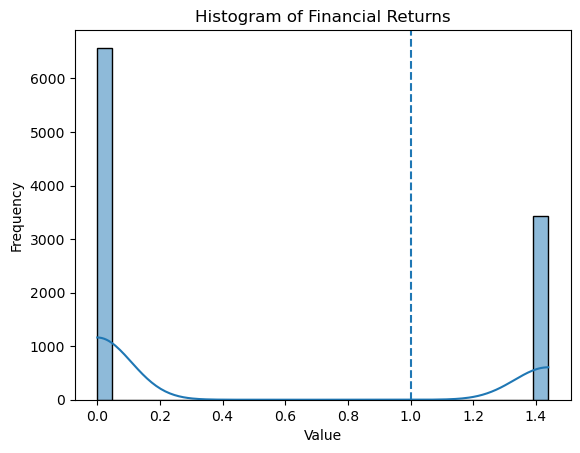

In [29]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=30, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [27]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [22]:
compute_objective_via_analytical(x=allocation_array,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 scenario=scenario_favorable)

-0.5449586866662952

In [ ]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [23]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               scenario=scenario_favorable)

my_expectation: 2.1351751111111104
my_sigma: 3.918049502381054
my_sigma: 3.918049502381054
my_expectation: 2.135175110808347
my_sigma: 3.9180495012250147
my_sigma: 3.9180495012250147
my_expectation: 2.135175111049139
my_sigma: 3.9180495015857035
my_sigma: 3.9180495015857035
my_expectation: 2.1351751120770985
my_sigma: 3.918049504362847
my_sigma: 3.918049504362847
my_expectation: 2.135175111010258
my_sigma: 3.9180495017123462
my_sigma: 3.9180495017123462
my_expectation: 2.135175111905735
my_sigma: 3.9180495047709694
my_sigma: 3.9180495047709694
my_expectation: 2.135175110878493
my_sigma: 3.9180495015403816
my_sigma: 3.9180495015403816
my_expectation: 2.1351751113982678
my_sigma: 3.918049505026489
my_sigma: 3.918049505026489
my_expectation: 2.135175110808347
my_sigma: 3.9180495012250147
my_sigma: 3.9180495012250147
my_expectation: 2.135175110894829
my_sigma: 3.918049501502048
my_sigma: 3.918049501502048
my_expectation: 2.135175111307205
my_sigma: 3.9180495028465265
my_sigma: 3.9180495028

In [24]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

-0.00017476527876247872
1.0


In [34]:
odds_sample_favorable[['Market', 'Sportsbook', 'Scenario', 'Odd', 'public_prob', 'real_prob']].assign(solution=np.round(solution, 3)).sort_values(['solution'], ascending=False)
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Market,Sportsbook,Scenario,Odd,public_prob,real_prob,solution
268,both_score,Megapari Sport,,2.20,0.454545,0.5251,0.171
258,both_score,1xBet,,2.20,0.454545,0.5251,0.171
262,both_score,NetBet,,2.10,0.476190,0.5251,0.077
266,both_score,18Bet,,2.03,0.492611,0.5251,0.055
260,both_score,Betobet,,2.03,0.492611,0.5251,0.055
272,both_score,Bet365,,2.00,0.500000,0.5251,0.050
270,both_score,Mr Green Sport,,2.00,0.500000,0.5251,0.050
264,both_score,Parimatch,,2.00,0.500000,0.5251,0.050
60,exact,Betobet,1 : 4,21.00,0.047619,0.0529,0.034
156,exact,18Bet,1 : 4,21.00,0.047619,0.0529,0.034
